# Introduction aux autoencodeurs


## Apprentissage supervisé et non supervisé


### Apprentissage supervisé


Dans les cours précédents, nous avons uniquement traité des cas d'apprentissage supervisé. En gros, il s'agit des situations où les données d'entraînement contiennent à la fois une entrée **x** et une sortie **y**. Le modèle doit alors prendre **x** en entrée et prédire **y**.
Par exemple, pour MNIST, on avait une image **x** et un label **y** représentant un chiffre entre 0 et 9. En segmentation, on utilisait une image **x** et un masque **y** en sortie.


### Apprentissage non supervisé


En apprentissage non supervisé, les données ne sont pas étiquetées, ce qui signifie qu'on a seulement **x** sans **y**. Dans ce cas, on ne peut pas prédire une valeur précise, mais on peut entraîner un modèle à regrouper des éléments similaires (on parle de clustering).
Dans ce cours, on se concentrera sur la détection d'anomalies non supervisée. L'idée est d'entraîner un modèle sur un certain type de données, puis de l'utiliser pour détecter des éléments qui diffèrent du jeu d'entraînement.


## Autoencodeur


### Architecture


Le modèle de base pour ce type de tâches s'appelle "autoencodeur". Son architecture ressemble à celle du U-Net que nous avons vu précédemment.
Voici l'architecture classique d'un autoencodeur :


Comme tu peux le voir, il a une forme de "sablier". L'idée de l'autoencodeur est de créer une représentation compressée des données d'entrée et de les reconstruire à partir de cette représentation. D'ailleurs, ce modèle peut aussi servir à compresser des données.


### Utilisation pour la détection d'anomalies non supervisée


Pour la détection d'anomalies non supervisée, prenons un exemple. On entraîne l'autoencodeur à reconstruire des images du chiffre 5. Une fois entraîné, il reconstruira parfaitement les images de 5. Si on veut détecter si une image est un 5 ou un autre chiffre, il suffit de la donner à l'autoencodeur. En analysant la qualité de la reconstruction ($image_{base} - image_{recons}$), on peut déterminer s'il s'agit d'un 5 ou non.
L'image suivante illustre ce principe :


## Application pratique sur MNIST


Pour illustrer ce qui a été décrit, nous allons entraîner un autoencodeur pour reconstruire les 5 avec PyTorch.


In [14]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

### Création des datasets d'entraînement et de test


In [15]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

Nous avons récupéré nos datasets d'entraînement/validation et de test. On veut ne garder que les 5 dans le dataset d'entraînement. Pour cela, supprimons les éléments qui ne contiennent pas le chiffre 5.


In [16]:
# On récupere les indices des images de 5
indices = [i for i, label in enumerate(dataset.targets) if label == 5]
# On créer un nouveau dataset avec uniquement les 5
filtered_dataset = torch.utils.data.Subset(dataset, indices)

On peut visualiser quelques images pour vérifier qu'on a bien que des 5.


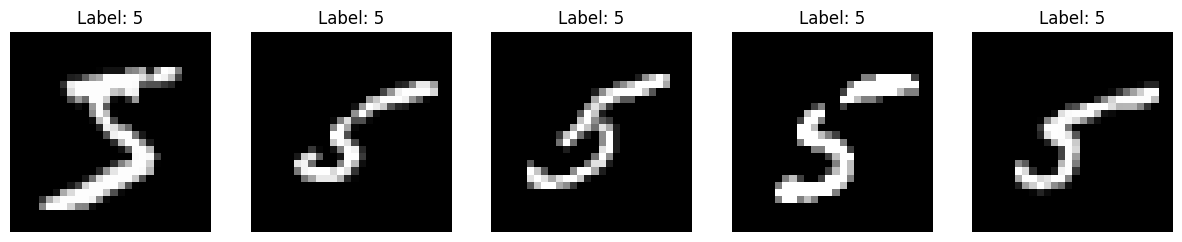

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
  image, label = filtered_dataset[i]
  image = image.squeeze().numpy() 
  axes[i].imshow(image, cmap='gray')
  axes[i].set_title(f'Label: {label}')
  axes[i].axis('off')
plt.show()

Divisons maintenant le dataset en parties d'entraînement et de validation, puis créons nos dataloaders.


In [18]:
train_dataset, validation_dataset=torch.utils.data.random_split(filtered_dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Création du modèle autoencodeur


Pour le dataset MNIST, une architecture peu profonde suffit pour obtenir de bons résultats.


In [19]:
class ae(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
      nn.Linear(28 * 28, 512), 
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
    )
    self.decoder = nn.Sequential(
      nn.Linear(128, 256),
      nn.ReLU(),
      nn.Linear(256, 512),
      nn.ReLU(),
      nn.Linear(512, 28 * 28),
      nn.Sigmoid()
    )
  
  def forward(self,x):
    x=x.view(-1,28*28) 
    x = self.encoder(x)
    x = self.decoder(x)
    recons=x.view(-1,28,28)
    return recons

In [20]:
model = ae()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

ae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Nombre de paramètres 1132944


### Entraînement du modèle


Pour la fonction de perte, nous utilisons MSELoss, qui correspond à l'erreur quadratique moyenne définie par :
$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
où $N$ est le nombre total de pixels dans l'image, $y_i$ est la valeur du pixel $i$ dans l'image originale, et $\hat{y}_i$ est la valeur du pixel $i$ dans l'image reconstruite.
C'est une fonction classique pour évaluer la qualité d'une reconstruction.


In [21]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
for i in range(epochs):
  loss_train=0
  for images, _ in train_loader:
    recons=model(images)
    loss=criterion(recons,images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, _ in val_loader:
    with torch.no_grad():
      recons=model(images)
      loss=criterion(recons,images)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.08228749781847
step 0 val loss 0.06261523813009262
step 1 train loss 0.06122465804219246
step 1 val loss 0.06214689463376999
step 2 train loss 0.06105153635144234
step 2 val loss 0.06189680099487305
step 3 train loss 0.06086035445332527
step 3 val loss 0.06180128455162048
step 4 train loss 0.0608210563659668
step 4 val loss 0.06169722229242325
step 5 train loss 0.06080913543701172
step 5 val loss 0.061976321041584015
step 6 train loss 0.060783520340919495
step 6 val loss 0.06190618872642517
step 7 train loss 0.06072703003883362
step 7 val loss 0.06161761283874512
step 8 train loss 0.06068740040063858
step 8 val loss 0.061624933034181595
step 9 train loss 0.060728199779987335
step 9 val loss 0.061608292162418365


Regardons maintenant la reconstruction des images du dataset de test.


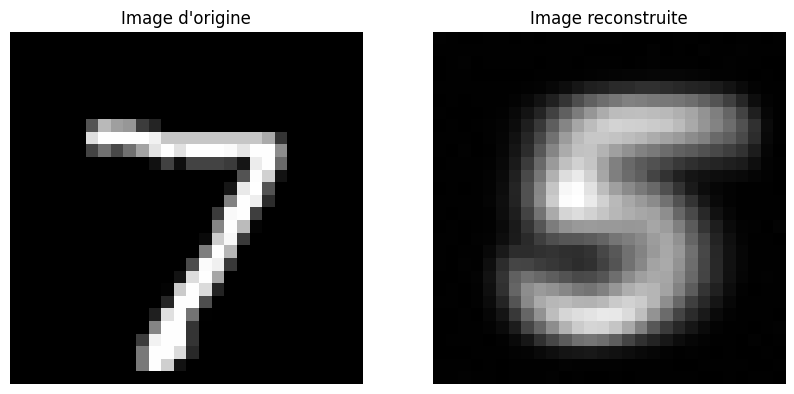

difference :  0.0687035545706749


In [23]:
images,_=next(iter(test_loader))

#Isolons un élément 
image=images[0].unsqueeze(0)
with torch.no_grad():
  recons=model(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image d'origine
axs[0].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Image d\'origine')
axs[0].axis('off')

# Image reconstruite
axs[1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
axs[1].set_title('Image reconstruite')
axs[1].axis('off')
plt.show()
print("difference : ", criterion(image,recons).item())

On remarque que la reconstruction du 7 est très mauvaise, ce qui permet de déduire qu'il s'agit d'une anomalie.
